### Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import mne
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
import seaborn as sns
import tsaug

from mat4py import loadmat

from tqdm import tqdm
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.decomposition import PCA

from pyriemann.estimation import Covariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Для кросс-корреляции
from scipy.signal import correlate

%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
#!pip install mne
#!pip install pyriemann

In [3]:
#!pipreqs . --force

## 1) Получаем набор данных и проводим аугментацию

### eyes open/eyes closed on EEG Motor Movement/Imagery Dataset

- EEG Motor Movement датасет состоит из 109 испытуемых
- Данные каждого испытуемого состоят из 14 выполненных тестов
- Мы сейчас сосредоточимся за заданиях 2 и 4 с классификацией Motor Imagery (MI)
In summary, the experimental runs were:
1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

Общее для всех объектов:

- Число каналов 64
- Частота измерений 160 Гц

Пусть метка 0 это Task 2, метка 1 это Task 4

In [2]:
class data():
    def __init__(self):
        pass

    def get_data(self):
        data = []

        for i in range(109):
            if len(str(i+1)) == 1:
                sub_number = '00'+str(i+1)
            elif len(str(i+1)) == 2:
                sub_number = '0'+str(i+1)
            else:
                sub_number = str(i+1)

            path_0 = os.path.join(os.path.dirname(os.getcwd()), 'code', 'eeg-motor-movementimagery-dataset', 'files', 'S' + sub_number, 'S' + sub_number + 'R04.edf')
            path_1 = os.path.join(os.path.dirname(os.getcwd()), 'code', 'eeg-motor-movementimagery-dataset', 'files', 'S' + sub_number, 'S' + sub_number + 'R06.edf')

            # colab
            #path_0 = os.path.join('/content/drive/My Drive/7_sem/diplom/', 'code', 'eeg-motor-movementimagery-dataset', 'files', 'S' + sub_number, 'S' + sub_number + 'R01.edf')
            #path_1 = os.path.join('/content/drive/My Drive/7_sem/diplom/', 'code', 'eeg-motor-movementimagery-dataset', 'files', 'S' + sub_number, 'S' + sub_number + 'R02.edf')


            X_0 = mne.io.read_raw_edf(path_0, preload=True, verbose = False).get_data()
            X_1 = mne.io.read_raw_edf(path_1, preload=True, verbose = False).get_data()
            data.append((X_0, 0))
            data.append((X_1, 1))
        self.data = np.array(data)

    # Аугментация
    def get_augmented_data(self, window_size = 610):
        self.get_data()
        augmented_data = []
        for time_series, label in self.data:
            divided_time_series = [time_series[:, i:i+window_size] for i in range(0, time_series.shape[1], window_size)]
            for ts in divided_time_series:
                augmented_data.append((ts, label))

        self.augmented_data = np.array(augmented_data)

        # Приводим к одному размеру окна
        new_augmented_data = []
        for i in range(len(self.augmented_data)):
            if self.augmented_data[i][0].shape[1] == 610:
                new_augmented_data.append(self.augmented_data[i])

        self.augmented_data = np.array(new_augmented_data)

`TODO Стоит добавить еще аугментаций и изучить методы аугментаций временных рядов`

In [3]:
dataset = data()
dataset.get_augmented_data()
augmented_data = dataset.augmented_data

In [26]:
augmented_data.shape

(6938, 2)

In [27]:
ts = np.array([augmented_data[i][0] for i in range(len(augmented_data))])
y = np.array([augmented_data[i][1] for i in range(len(augmented_data))])

### Разделим данные на тренировочные и тестовые

In [28]:
ts_train, ts_test, y_train, y_test = train_test_split(ts, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
print(f'In train data class 0: {np.sum(1 - y_train)}, class 1: {np.sum(y_train)}')

In train data class 0: 2775, class 1: 2775


## Выпрямим в вектор временные ряды и применим SVM

In [18]:
ts_train_flatten = np.array([ts.flatten() for ts in ts_train])
ts_test_flatten = np.array([ts.flatten() for ts in ts_test])

In [19]:
ts_train_flatten.shape

(4169, 39040)

In [15]:
clf = SVC(kernel='rbf')

# cross validation
accuracy = cross_val_score(clf, ts_train_flatten, y_train)

print(accuracy.mean())

0.7322381163812797


In [16]:
clf = SVC(kernel='rbf')
clf.fit(ts_train_flatten, y_train)

y_pred = clf.predict(ts_test_flatten)

In [17]:
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on test 0.697, f1-score on test 0.731


## Воспользуемся библиотекой pyriemann

### Перейдем в касательное пространство и воспользуемся классическими методами классификации

In [30]:
ts_train.shape # Ntrials x Nchannels X Nsamples

(5550, 64, 610)

### 1) SVM

In [31]:
# build pipeline
covest = Covariances()
ts = TangentSpace()
svc = SVC(kernel='rbf')

clf = make_pipeline(covest,ts,svc)
# cross validation
accuracy = cross_val_score(clf, ts_train, y_train)

print(accuracy.mean())

0.8495495495495495


In [32]:
covest = Covariances()
ts = TangentSpace()
svc = SVC(kernel='rbf')

clf = make_pipeline(covest,ts,svc)
clf.fit(ts_train, y_train)

y_pred = clf.predict(ts_test)

In [33]:
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on test 0.882, f1-score on test 0.882


Аналогичным образом попробуем другие классические методы классификации после переход в касательное пространство

### 2) LogisticRegression

In [58]:
covest = Covariances()
ts = TangentSpace()
logreg = LogisticRegression()

clf = make_pipeline(covest,ts, logreg)
# cross validation
accuracy = cross_val_score(clf, ts_train, y_train)

print(accuracy.mean())

0.6944144144144143


In [59]:
covest = Covariances()
ts = TangentSpace()
logreg = LogisticRegression()

clf = make_pipeline(covest,ts,logreg)
clf.fit(ts_train, y_train)

y_pred = clf.predict(ts_test)

In [60]:
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on test 0.731, f1-score on test 0.729


### 3) DecisionTreeClassifier

In [61]:
covest = Covariances()
ts = TangentSpace()
rf= RandomForestClassifier(n_estimators=200)

clf = make_pipeline(covest,ts, rf)
# cross validation
accuracy = cross_val_score(clf, ts_train, y_train)
print(accuracy.mean())

0.7464864864864864


In [62]:
covest = Covariances()
ts = TangentSpace()
rf= RandomForestClassifier(n_estimators=200)

clf = make_pipeline(covest,ts,rf)
clf.fit(ts_train, y_train)

y_pred = clf.predict(ts_test)

In [63]:
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on test 0.755, f1-score on test 0.752


### 4) Применим PCA

In [64]:
# SVM
covest = Covariances()
ts = TangentSpace(metric='riemann')
pca = PCA(1000)
svc = SVC(kernel='rbf')

clf = make_pipeline(covest,ts,pca,svc)
# cross validation
accuracy = cross_val_score(clf, ts_train, y_train)

print(accuracy.mean())

0.8531531531531531


In [65]:
clf = make_pipeline(covest,ts,pca,svc)
clf.fit(ts_train, y_train)

y_pred = clf.predict(ts_test)

In [66]:
print(f'Accuracy on test {round(accuracy_score(y_test, y_pred), 3)}, f1-score on test {round(f1_score(y_test, y_pred), 3)}')

Accuracy on test 0.883, f1-score on test 0.883


### 5) Полносвязная нейронная сеть

In [38]:
covest = Covariances()
ts = TangentSpace(metric='riemann')
preprocess = make_pipeline(covest,ts)
preprocess.fit(ts_train, y_train)

X_train = preprocess.transform(ts_train)
X_test = preprocess.transform(ts_test)

In [39]:
def get_loader(X, y, batch_size=64):
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(),
                                       torch.from_numpy(y).long())
    train_loader = torch.utils.data.DataLoader(train,
                                               batch_size=batch_size)
    return train_loader

In [40]:
def count_parameters(model):
    return sum(param.data.numpy().size for param \
               in model.parameters() if param.requires_grad)

In [41]:
def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()

    for batch_idx, (data_inputs, data_labels) in enumerate(train_loader):

        ## Step 1: Move input data to device (only strictly necessary if we use GPU)
        data_inputs = data_inputs.to(device)
        data_labels = data_labels.to(device)

        ## Step 2: Run the model on the input data
        preds = model(data_inputs)

        ## Step 3: Calculate the loss
        loss = criterion(preds, data_labels.long())
        ## Step 4: Perform backpropagation
        # Before calculating the gradients, we need to ensure that they are all zero.
        # The gradients would not be overwritten, but actually added to the existing ones.
        optimizer.zero_grad()

        # Perform backpropagation
        loss.backward()

        ## Step: Update the parameters
        optimizer.step()


def evaluate_loss_acc(loader, model, criterion, device):
    model.eval() # Set model to eval mode
    loss, true_preds, num_preds = 0., 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)

            # Calculate the loss on the batch
            batch_loss = criterion(preds, data_labels.long())
            # Add batch_loss to the summary loss
            loss += batch_loss * data_labels.shape[0]

            preds = torch.softmax(preds, dim = 1) # Softmax to map predictions between 0 and 1
            pred_labels = torch.argmax(preds, dim=1)

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    loss = loss / num_preds
    return (loss, acc)
    print(f"Loss of the model: {loss}%")
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")



def train(model, opt, train_loader, test_loader, criterion, n_epochs, \
          device, verbose=True):

    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        train_epoch(model, opt, train_loader, criterion, device)
        train_loss, train_acc = evaluate_loss_acc(train_loader,
                                                  model, criterion,
                                                  device)
        val_loss, val_acc = evaluate_loss_acc(test_loader, model,
                                              criterion, device)

        train_log.append(train_loss.cpu())
        train_acc_log.append(train_acc.cpu())

        val_log.append(val_loss.cpu())
        val_acc_log.append(val_acc.cpu())

        if verbose:
             print (('Epoch [%d/%d], Loss (train/test): %.4f/%.4f,'+\
               ' Acc (train/test): %.4f/%.4f' )
                   %(epoch+1, n_epochs, \
                     train_loss, val_loss, train_acc, val_acc))

    return train_log, train_acc_log, val_log, val_acc_log

---
Обучим нейронную сеть

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(2080, 1040),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Linear(1040, 500),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Linear(500, 100),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Linear(100, 20),
            nn.ReLU())
        self.layer5 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

In [35]:
net = Net()

In [36]:
criterion = nn.CrossEntropyLoss() # loss includes softmax
optimizer = optim.SGD(net.parameters(), lr=0.1)
#optimizer = optim.Adam(net.parameters(), lr=0.001)

In [37]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

net = net.to(device)

In [42]:
n_epochs = 30

train_loader = get_loader(X_train, y_train, batch_size=64)
test_loader = get_loader(X_test, y_test, batch_size=64)

train_log, train_acc_log, test_log, test_acc_log = train(net, optimizer, train_loader, test_loader, criterion, n_epochs, device, verbose=True)

Epoch [1/30], Loss (train/test): 0.6922/0.6926, Acc (train/test): 0.5362/0.5173
Epoch [2/30], Loss (train/test): 0.6910/0.6920, Acc (train/test): 0.5843/0.5584
Epoch [3/30], Loss (train/test): 0.6886/0.6908, Acc (train/test): 0.6130/0.5627
Epoch [4/30], Loss (train/test): 0.6818/0.6877, Acc (train/test): 0.6207/0.5562
Epoch [5/30], Loss (train/test): 0.6513/0.6719, Acc (train/test): 0.7040/0.6131
Epoch [6/30], Loss (train/test): 0.6231/0.6657, Acc (train/test): 0.6852/0.6448
Epoch [7/30], Loss (train/test): 0.5282/0.6105, Acc (train/test): 0.7600/0.7010
Epoch [8/30], Loss (train/test): 0.3491/0.4867, Acc (train/test): 0.8737/0.7644
Epoch [9/30], Loss (train/test): 0.3064/0.4599, Acc (train/test): 0.9031/0.7853
Epoch [10/30], Loss (train/test): 0.2367/0.3953, Acc (train/test): 0.9272/0.8314
Epoch [11/30], Loss (train/test): 0.1949/0.4113, Acc (train/test): 0.9268/0.8184
Epoch [12/30], Loss (train/test): 0.1685/0.3708, Acc (train/test): 0.9447/0.8401
Epoch [13/30], Loss (train/test): 0.1

### 6) LSTM

In [64]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# Параметры модели
input_size = 2080  # Размерность касательного риманова пространства
hidden_size = 128  # Размер скрытого состояния LSTM
num_classes = 2    # Количество классов в задаче

In [65]:
lstm = LSTMClassifier(input_size, hidden_size, num_classes)

In [66]:
criterion = nn.CrossEntropyLoss() # loss includes softmax
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

In [67]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

lstm = lstm.to(device)

In [68]:
train_loader = get_loader(X_train, y_train, batch_size=64)
test_loader = get_loader(X_test, y_test, batch_size=64)

In [69]:
# Процесс обучения
num_epochs = 30
for epoch in range(num_epochs):
    for inputs, labels in train_loader:  # train_loader - загрузчик данных для обучения
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Передача данных касательного риманова пространства в LSTM
        inputs = inputs.unsqueeze(1)  # Добавляем размерность канала

        # Прямой проход через модель
        outputs = lstm(inputs)

        # Вычисление функции потерь
        loss = criterion(outputs.squeeze(), labels)

        # Обратное распространение и оптимизация модели
        loss.backward()
        optimizer.step()

    # Вывод информации о процессе обучения
    if (epoch+1) % 1 == 0:
        print(f'Эпоха [{epoch+1}/{num_epochs}], Потери: {loss.item():.4f}')

# Тестирование модели
lstm.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:  # test_loader - загрузчик данных для тестирования
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.unsqueeze(1)  # Добавляем размерность канала
        outputs = lstm(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Acc on test: {100 * accuracy:.2f}%')

Эпоха [1/30], Потери: 0.3493
Эпоха [2/30], Потери: 0.1481
Эпоха [3/30], Потери: 0.0614
Эпоха [4/30], Потери: 0.0230
Эпоха [5/30], Потери: 0.0094
Эпоха [6/30], Потери: 0.0057
Эпоха [7/30], Потери: 0.0041
Эпоха [8/30], Потери: 0.0030
Эпоха [9/30], Потери: 0.0020
Эпоха [10/30], Потери: 0.0013
Эпоха [11/30], Потери: 0.0010
Эпоха [12/30], Потери: 0.0008
Эпоха [13/30], Потери: 0.0007
Эпоха [14/30], Потери: 0.0006
Эпоха [15/30], Потери: 0.0005
Эпоха [16/30], Потери: 0.0005
Эпоха [17/30], Потери: 0.0004
Эпоха [18/30], Потери: 0.0004
Эпоха [19/30], Потери: 0.0003
Эпоха [20/30], Потери: 0.0003
Эпоха [21/30], Потери: 0.0003
Эпоха [22/30], Потери: 0.0003
Эпоха [23/30], Потери: 0.0002
Эпоха [24/30], Потери: 0.0002
Эпоха [25/30], Потери: 0.0002
Эпоха [26/30], Потери: 0.0002
Эпоха [27/30], Потери: 0.0002
Эпоха [28/30], Потери: 0.0002
Эпоха [29/30], Потери: 0.0001
Эпоха [30/30], Потери: 0.0001
Acc on test: 95.70%


----

---

Электроды на голове обследуемого располагаются в строго определенных местах в соответствии с международной системой "10-20%". Эта система регламентируется Международной федерацией клинической нейрофизиологии (IFCN). В России опубликованы Рекомендации экспертного совета по нейрофизиологии Российской противоэпилептической лиги по проведению рутинной ЭЭГ. В этих рекомендация кроме всего прочего перечислены рекомендуемые к использованию монтажи регистрации. Иногда для более точной локализации источников патологической активности применяется более плотное расположение ЭЭГ-электродов на голове обследуемого. Международная система "10-10%" включает 64 активных электрода плюс 10 дополнительных электродов скуловой дуги.

В нашем датасете применяются 64-канальная система 10-10

Названия электродов включают первую букву латинского названия области, на которую ставится электрод, и номер, указывающий сторону и расположение электрода в пределах этой области.: pre-frontal (Fp)(лобный полюс), frontal (F)(лобная), temporal (T)(височная), parietal (P)(теменная), occipital (O)(затылочная), central (C)(центральная), midline (Z). Нечетные номера указывают на левое полушарие, четные — на правое.
Сагиттальные (расположенные на средней
линии) электроды вместо цифры имеют добавочную букву «z» - Fz, Cz, Pz. Электроды под четными
числами располагаются на правой половине черепа, нечетные электроды– на левой половине.
Электроды с меньшим номером располагаются ближе к средней линии, с большими номерами – дальше
от средней линии. Электроды F7 и F8 расположены не над лобной долей, соответственно их названиям,
а над височной долей. Таким образом, они записывают сигналы от височной доли в дополнение к
лобной доле. Геометрический аспект включен в названия электродов, однако, P7 и P8 вводят в
заблуждение, так как на самом деле они расположены над задней частью височной, а не теменной
области.
Новые буквенные коды MCN для промежуточных электродных мест:

- AF – между Fp и F
- FC – между F и C
- FT – между F и T
- CP – между C и P
- TP – между T и P
- PO – между P и O

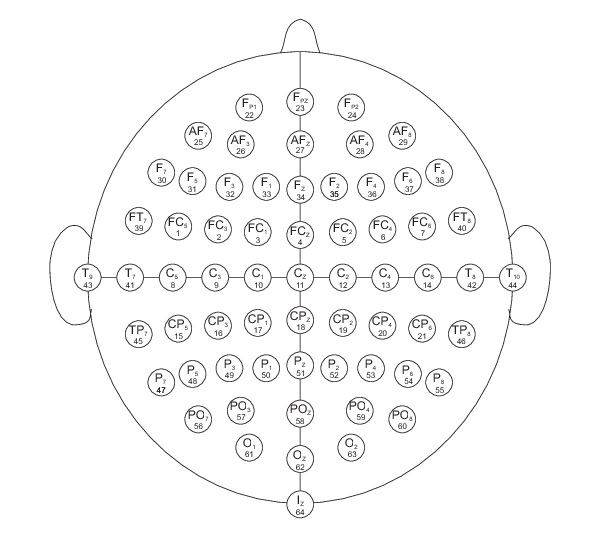

In [71]:
from IPython.display import Image
Image('64_channel_eeg.png', width=600, height=300)

In [4]:
data = dataset.data

In [5]:
ts = data[44][0]

Голова представляет собой почти закрытый сферический объем, в котором протекают потоки
электричества. Следовательно, негативные потенциалы на коже головы имеют примерно такую же
величину, как и положительные потенциалы, а сумма всех потенциалов на поверхности черепа близка к
нулю. Поэтому, суммируя показатели напряжения всех регистрирующих электродов, можно представить
общий вольтаж в виде базовой линии, относительно которой некоторые электроды отрицательные,
другие положительные, а сумма их потенциалов близка к нулю. Однако, электроды ЭЭГ
не равномерно распределены по поверхности головы. Согласно схеме размещения электродов 10–20
большая часть электродов расположена на верхней части головы, что дает смещение линии нулевого
напряжения вверх. Это смещение может быть уменьшено, если электродный массив включает в себя
нижне-височные электроды.

<Axes: >

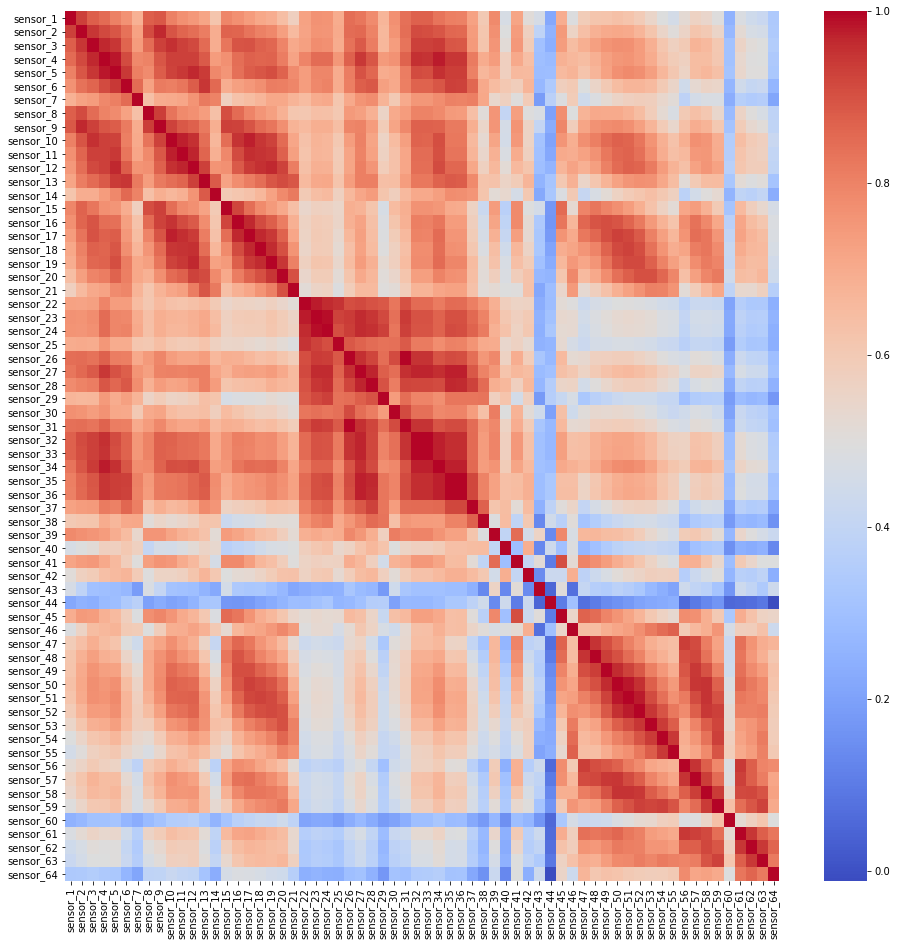

In [7]:
df = pd.DataFrame(ts.T, columns=[f'sensor_{i+1}' for i in range(ts.T.shape[1])])
plt.figure(figsize=(16, 16))
sns.heatmap(df.corr(method='pearson'), cmap='coolwarm')

In [15]:
ts1 = ts[21][:5000]
ts2 = ts[22][:5000]
ts3 = ts[23][:5000]
ts4 = ts[60][:5000]

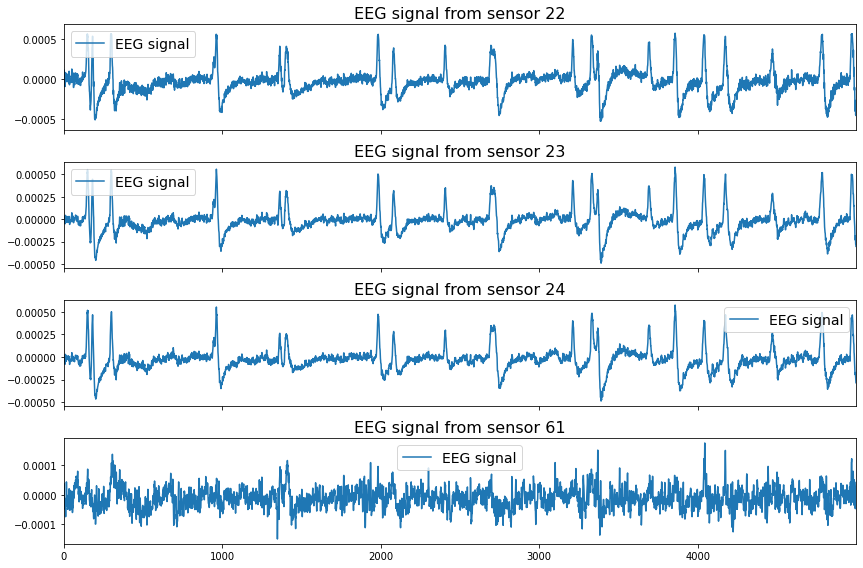

In [16]:
plt.rcParams['figure.figsize'] = (12, 8)
fig, (ax_ts1, ax_ts2, ax_ts3, ax_ts4) = plt.subplots(4, 1, sharex=True, layout='constrained')
ax_ts1.plot(ts1, label = 'EEG signal')
ax_ts1.set_title('EEG signal from sensor 22', fontsize = '16')
ax_ts1.legend(fontsize = '14')
ax_ts2.plot(ts2, label = 'EEG signal')
ax_ts2.set_title('EEG signal from sensor 23', fontsize = '16')
ax_ts2.legend(fontsize = '14')
ax_ts3.plot(ts3, label = 'EEG signal')
ax_ts3.set_title('EEG signal from sensor 24', fontsize = '16')
ax_ts3.legend(fontsize = '14')
ax_ts4.plot(ts4, label = 'EEG signal')
ax_ts4.set_title('EEG signal from sensor 61', fontsize = '16')
ax_ts4.legend(fontsize = '14')
ax_ts1.margins(0, 0.1)
fig.tight_layout()
plt.show()

---

### Кросс-корреляция

При исследовании интервальной корреляционной функции необходимо отметить, что высокие значения функции при автокорреляции – это возможное следствие возврата к исходному функциональному состоянию, а в случае кросскорреляционной функции – задержки передачи сигнала между отведениями.

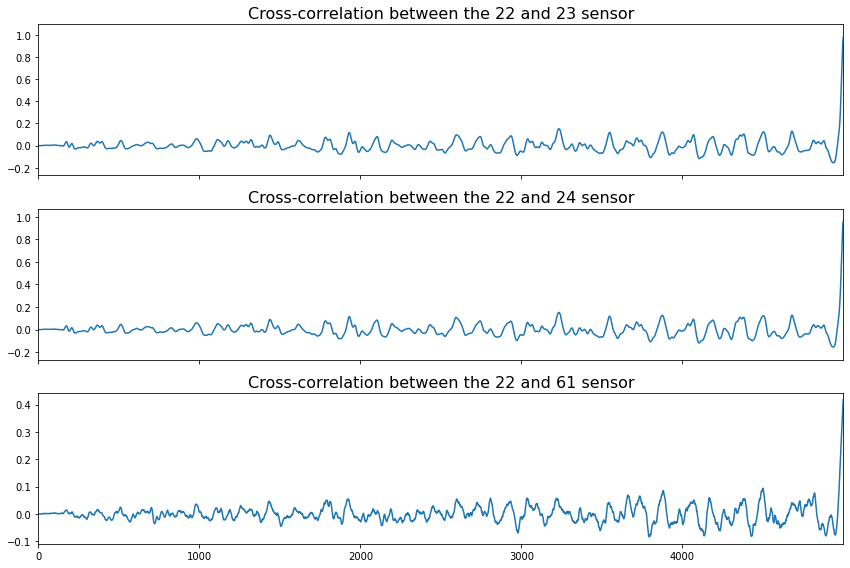

In [17]:
from scipy.signal import correlate
import statsmodels.api as sm

corr12 = sm.tsa.stattools.ccf(ts2, ts1, adjusted=False)
corr13 = sm.tsa.stattools.ccf(ts3, ts1, adjusted=False)
corr14 = sm.tsa.stattools.ccf(ts4, ts1, adjusted=False)

# Remove padding and reverse the order
corr12 = corr12[0:(len(ts2)+1)][::-1] 
corr13 = corr13[0:(len(ts3)+1)][::-1]
corr14 = corr14[0:(len(ts4)+1)][::-1]

fig, (ax_corr12, ax_corr13, ax_corr14) = plt.subplots(3, 1, sharex=True, layout='constrained')
ax_corr12.plot(corr12)
ax_corr12.set_title('Cross-correlation between the 22 and 23 sensor', fontsize = '16')
ax_corr13.plot(corr13)
ax_corr13.set_title('Cross-correlation between the 22 and 24 sensor', fontsize = '16')
ax_corr14.plot(corr14)
ax_corr14.set_title('Cross-correlation between the 22 and 61 sensor', fontsize = '16')
ax_corr12.margins(0, 0.1)
ax_corr13.margins(0, 0.1)
fig.tight_layout()
plt.show()

### Посмотрим на автокорреляцию

Для стационарных временных рядов автокорреляционная функция стремится к 0. Чем меньше в ЭЭГ ритмической активности, тем быстрее происходит затухание. Оцениваемыми параметрами на автокоррелограмме могут быть: 1) интервал корреляции — время, в течение которого корреляционная связь «затухает» (исчезает); 2) декремент затухания, отражающий устойчивость ритмической составляющей; 3) средний период колебаний характеризует периодическую составляющую, имеющую максимальную амплитуду. Таким образом, автокорреляционный анализ позволяет выделить ритмическую активность и случайные процессы на ЭЭГ

ЭЭГ не является стационарным процессом

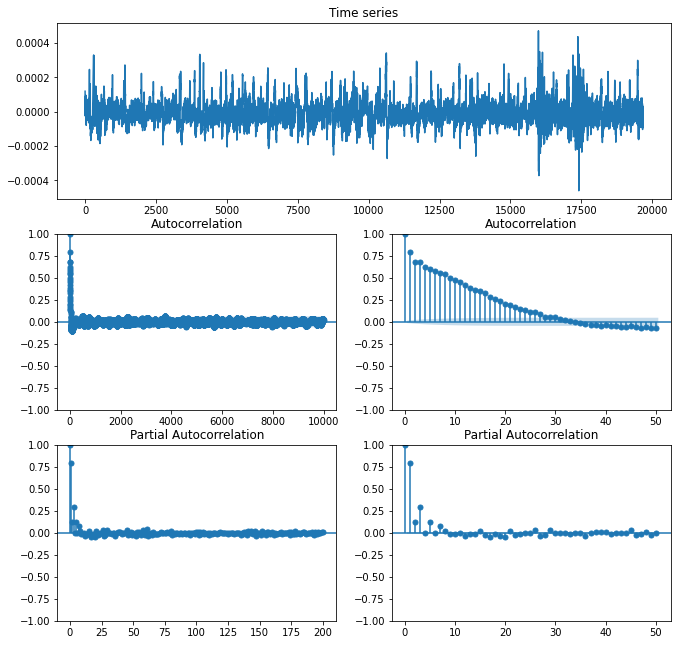

In [145]:
import statsmodels.tsa.api as smt

ts_0 = ts[0]

fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_0)
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_0, lags=10000, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_0, lags=200, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_0, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_0, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

---

### Transfer Entropy

In [222]:
ts = data[44][0]

ts41 = ts[40]
ts24 = ts[23]
ts64 = ts[63]

In [226]:
from PyIF import te_compute as te

TE = te.te_compute(ts24, ts64, k=1, embedding=1)

print(TE)

-0.9070133754689378


---

### Тест Грейнджера

In [227]:
from pandas.plotting import lag_plot

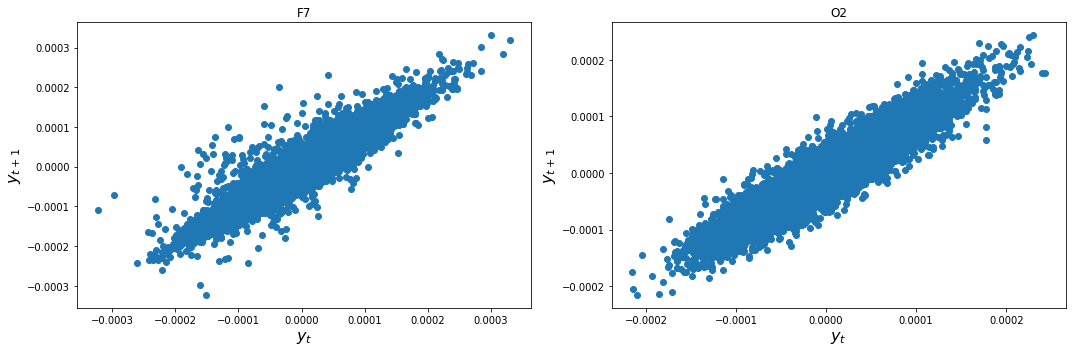

In [284]:
# firstly plot lags to check the stationarity
def lag_plots(df):
    f, ax = plt.subplots(1,2, figsize = (15,5))
    
    for i, name in enumerate(['F7', 'O2']):
        lag_plot(df[name], ax = ax[i])
        ax[i].set_title(name)
    ax[0].set_ylabel('$y_{t+1}$', fontsize = 16)
    ax[0].set_xlabel('$y_t$', fontsize = 16)
    ax[1].set_ylabel('$y_{t+1}$', fontsize = 16)
    ax[1].set_xlabel('$y_t$', fontsize = 16)

    plt.tight_layout()
lag_plots(df)

In [285]:
df_diff = df.copy()

df_diff['F7'] = df_diff['F7']
df_diff['O2'] = df_diff['O2']

#df_diff = df_diff.dropna(axis=0)

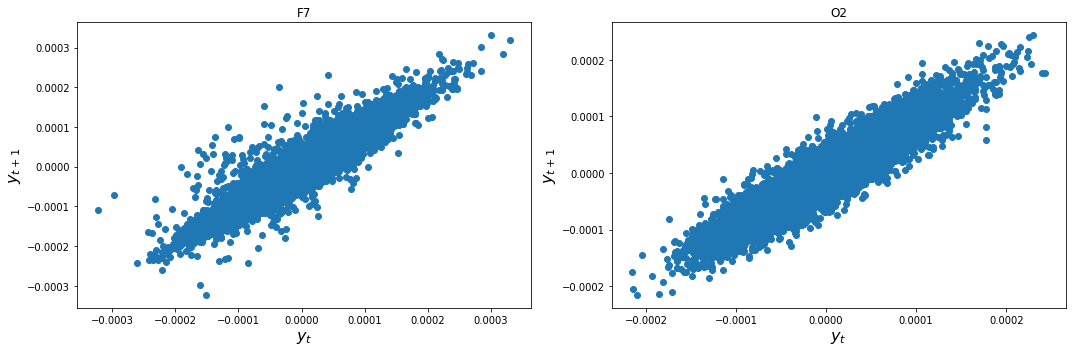

In [286]:
lag_plots(df_diff)

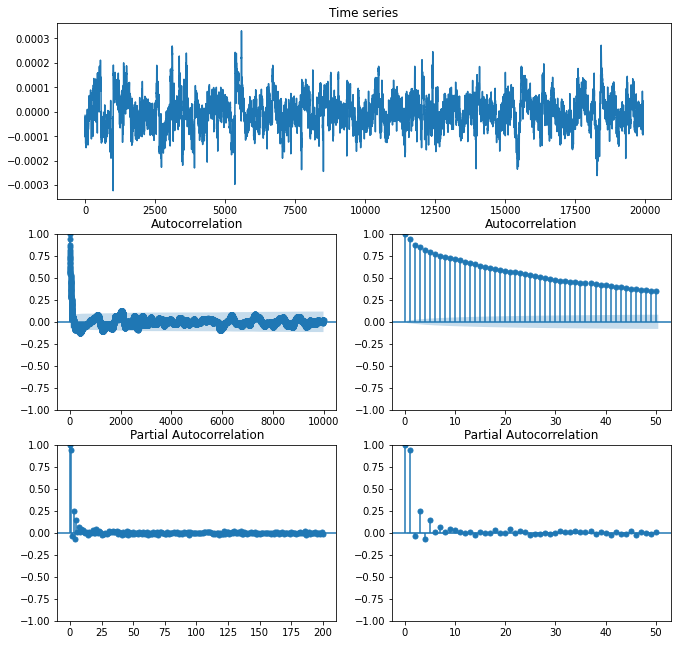

In [274]:
ts_C5 = df_diff['F7'].values

fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_C5)
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_C5, lags=10000, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_C5, lags=200, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_C5, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_C5, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

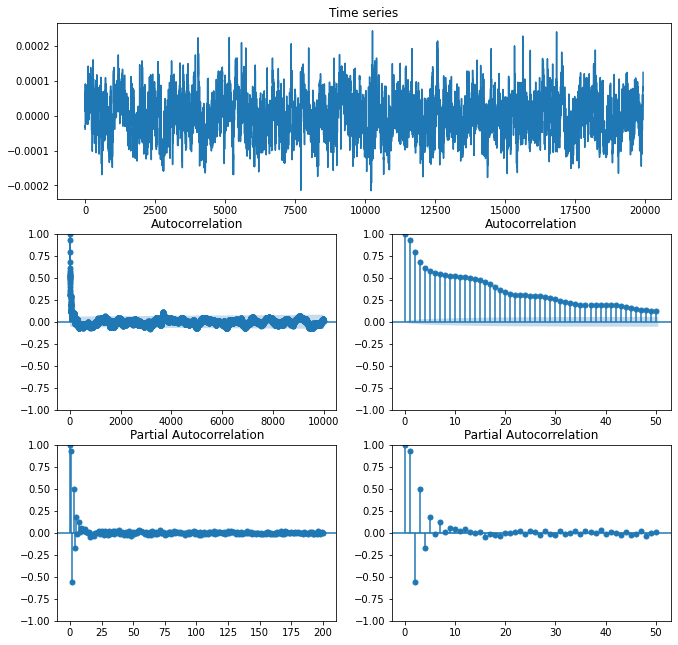

In [287]:
ts_O2 = df_diff['O2'].values

fig, axs = plt.subplots(3, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(ts_O2)
axbig.set_title('Time series')

smt.graphics.plot_acf(ts_O2, lags=10000, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(ts_O2, lags=200, ax=axs[2,0], alpha=0.05)

smt.graphics.plot_acf(ts_O2, lags=50, ax=axs[1,1], alpha=0.05)
smt.graphics.plot_pacf(ts_O2, lags=50, ax=axs[2,1], alpha=0.05)
plt.show()

Из графиков выше следует, что ряды теперь можно считать стационарными, следовательно, можно использовать тест Грэнджера на причинность.

In [295]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     56
BIC     19
HQIC    28
FPE     56
dtype: int32


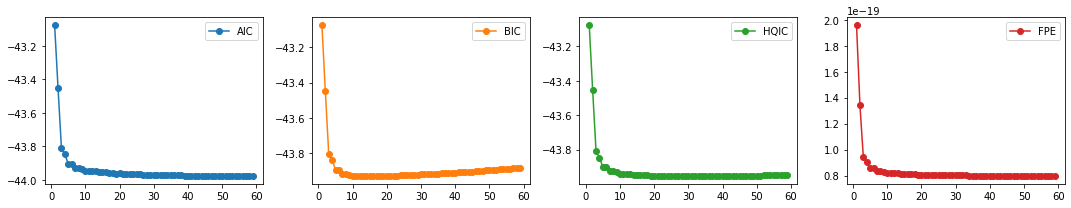

In [296]:
select_p(df_diff[['F7', 'O2']])

In [297]:
p = 19

In [298]:
from statsmodels.tsa.stattools import grangercausalitytests
def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [299]:
granger_causation_matrix(df_diff[['F7', 'O2']], ['F7', 'O2'], p) 

,F7_x,O2_x
F7_y,1.0,0.0
O2_y,0.0,1.0


Если полученное значение на пересечении в таблице < 0.05 (significance level), то это X вызывает Y. (Y является следствием X)
В тесте Грэнджера последовательно проверяются две нулевые гипотезы: «x не является причиной y по Грэнджеру» и «у не является причиной x по Грэнджеру»

---

In [229]:

reader = mne.io.read_raw_edf('eeg-motor-movementimagery-dataset/files/S001/S001R04.edf',preload=True)
annotations = reader.annotations
codes = annotations.description

df = pd.DataFrame(reader.get_data().T, columns=[channel.replace(".","") for channel in reader.ch_names])
df = df[~(df == 0).all(axis=1)]
timeArray = np.array([round(x,5) for x in np.arange(0,len(df)/160,.00625)])

codeArray = []     
counter = 0
for timeVal in timeArray:
    if timeVal in annotations.onset:
        counter += 1
    codeArray.append(codes[counter-1])

df["target"] = np.array(codeArray).T

Extracting EDF parameters from c:\Users\Чёрный господин\Documents\GitHub\project_VKR\code\eeg-motor-movementimagery-dataset\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


In [230]:
df

,Fc5,Fc3,Fc1,Fcz,Fc2,Fc4,Fc6,C5,C3,C1,...,Po7,Po3,Poz,Po4,Po8,O1,Oz,O2,Iz,target
0,-0.000005,0.000002,0.000037,0.000039,0.000030,0.000026,-0.000016,-0.000014,0.000004,0.000018,...,-0.000008,-0.000035,-0.000045,-0.000066,-0.000039,-0.000033,-0.000048,-0.000039,-0.000039,T0
1,-0.000012,-0.000024,0.000001,-0.000002,-0.000015,-0.000022,-0.000055,-0.000036,-0.000027,-0.000025,...,-0.000040,-0.000068,-0.000065,-0.000084,-0.000052,-0.000021,-0.000042,-0.000031,-0.000034,T0
2,-0.000077,-0.000078,-0.000059,-0.000065,-0.000063,-0.000055,-0.000067,-0.000088,-0.000071,-0.000065,...,-0.000022,-0.000050,-0.000035,-0.000048,-0.000018,-0.000020,-0.000042,-0.000029,-0.000027,T0
3,-0.000066,-0.000067,-0.000050,-0.000065,-0.000060,-0.000055,-0.000068,-0.000062,-0.000053,-0.000054,...,-0.000060,-0.000078,-0.000064,-0.000068,-0.000041,-0.000044,-0.000062,-0.000034,-0.000043,T0
4,-0.000045,-0.000055,-0.000033,-0.000053,-0.000054,-0.000063,-0.000083,-0.000052,-0.000050,-0.000053,...,-0.000055,-0.000070,-0.000054,-0.000063,-0.000037,-0.000060,-0.000070,-0.000034,-0.000045,T0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19915,-0.000018,-0.000006,0.000010,0.000004,-0.000006,-0.000017,-0.000042,-0.000050,0.000010,0.000031,...,0.000064,0.000053,0.000070,0.000034,0.000036,0.000105,0.000095,0.000071,0.000050,T1
19916,-0.000026,-0.000024,-0.000007,-0.000006,-0.000016,-0.000030,-0.000047,-0.000064,-0.000004,0.000014,...,0.000035,0.000030,0.000055,0.000030,0.000034,0.000072,0.000079,0.000072,0.000052,T1
19917,-0.000004,-0.000007,0.000005,0.000011,0.000006,0.000002,0.000008,-0.000036,0.000017,0.000036,...,0.000035,0.000032,0.000063,0.000049,0.000058,0.000053,0.000081,0.000090,0.000073,T1
19918,0.000027,0.000015,0.000022,0.000030,0.000011,-0.000005,-0.000035,0.000003,0.000045,0.000063,...,0.000029,0.000023,0.000055,0.000053,0.000069,0.000053,0.000092,0.000111,0.000094,T1
